<a href="https://colab.research.google.com/github/skywalker0803r/deep-learning-ian-goodfellow/blob/master/autoencoder_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import keras
from keras import layers
import numpy as np
import requests
import tensorflow as tf
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from keras.datasets import mnist,cifar10,cifar100

# data

In [48]:
(x_train, _), (x_test, _) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(50000, 3072)
(10000, 3072)


# model

In [49]:
url = 'https://gist.githubusercontent.com/skywalker0803r/e2502cb54a30f57bfb703ad9c9c8284a/raw/209a4711e3273d98792616d932adf80b3e3591b2/autoencoder_knn.py'
exec(requests.get(url).text)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001/20)
model = autoencoder_knn(input_dim=x_train.shape[1],encoding_dim=256,optimizer=optimizer)

NearestNeighbors(algorithm='ball_tree', n_neighbors=1)
Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 3072)]            0         
                                                                 
 dense_14 (Dense)            (None, 256)               786688    
                                                                 
 dense_15 (Dense)            (None, 3072)              789504    
                                                                 
Total params: 1,576,192
Trainable params: 1,576,192
Non-trainable params: 0
_________________________________________________________________
None


# train

Epoch 1/100
391/391 [==============================] - 3s 6ms/step - loss: 0.0689
Epoch 2/100
391/391 [==============================] - 2s 6ms/step - loss: 0.0282
Epoch 3/100
391/391 [==============================] - 2s 6ms/step - loss: 0.0227
Epoch 4/100
391/391 [==============================] - 2s 6ms/step - loss: 0.0202
Epoch 5/100
391/391 [==============================] - 2s 6ms/step - loss: 0.0183
Epoch 6/100
391/391 [==============================] - 2s 6ms/step - loss: 0.0168
Epoch 7/100
391/391 [==============================] - 2s 6ms/step - loss: 0.0154
Epoch 8/100
391/391 [==============================] - 2s 6ms/step - loss: 0.0143
Epoch 9/100
391/391 [==============================] - 2s 6ms/step - loss: 0.0134
Epoch 10/100
391/391 [==============================] - 2s 6ms/step - loss: 0.0126
Epoch 11/100
391/391 [==============================] - 2s 6ms/step - loss: 0.0119
Epoch 12/100
391/391 [==============================] - 2s 6ms/step - loss: 0.0113
Epoch 13/100


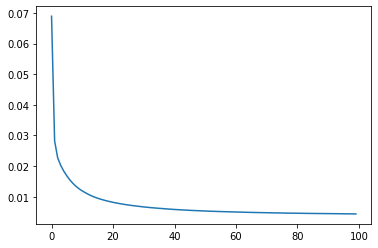

In [50]:
model.train(x_train,epochs=100,batch_size=128)

# test

No handles with labels found to put in legend.


第0張 距離:6.025


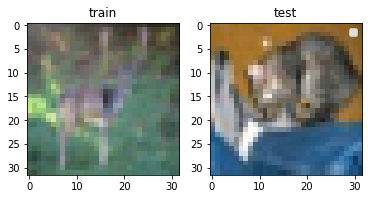

No handles with labels found to put in legend.


第1張 距離:6.842


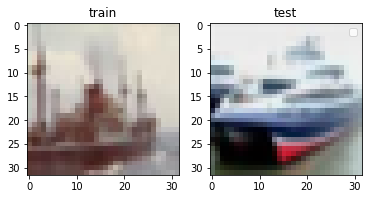

No handles with labels found to put in legend.


第2張 距離:5.26


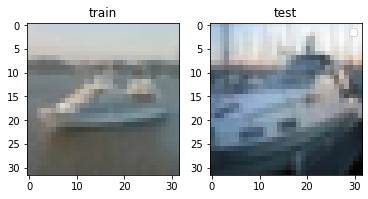

No handles with labels found to put in legend.


第3張 距離:4.4


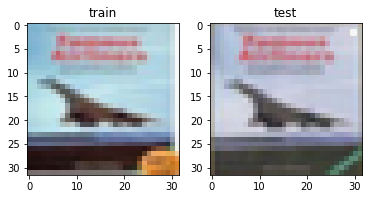

No handles with labels found to put in legend.


第4張 距離:4.974


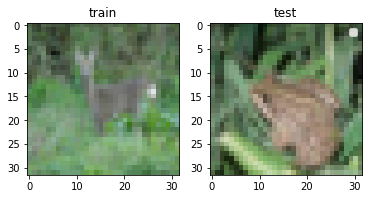

In [51]:
n = 5
distance,index = model.predict(x_test[:n].reshape(n,-1))
for i in range(n):
  print(f'第{i}張 距離:{round(distance[i][0],3)}')
  plt.figure()
  plt.subplot(1,2,1)
  plt.title('train')
  plt.imshow(x_train[index[i][0]].reshape(32,32,3))
  plt.subplot(1,2,2)
  plt.title('test') 
  plt.imshow(x_test[i].reshape(32,32,3))
  plt.legend()
  plt.show()

No handles with labels found to put in legend.


第0張 距離:0.0


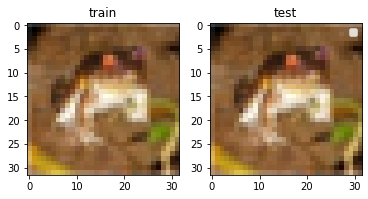

No handles with labels found to put in legend.


第1張 距離:0.0


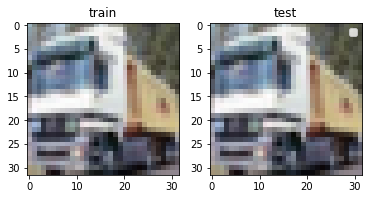

No handles with labels found to put in legend.


第2張 距離:0.0


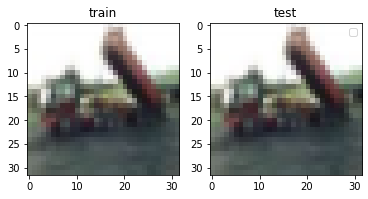

In [61]:
n = 3
noise = np.random.uniform(0,0.2,size=x_train.shape)
x_test = x_train #+ noise
distance,index = model.predict(x_test[:n].reshape(n,-1))
for i in range(n):
  print(f'第{i}張 距離:{round(distance[i][0],3)}')
  plt.figure()
  plt.subplot(1,2,1)
  plt.title('train')
  plt.imshow(x_train[index[i][0]].reshape(32,32,3))
  plt.subplot(1,2,2)
  plt.title('test') 
  plt.imshow(x_test[i].reshape(32,32,3))
  plt.legend()
  plt.show()